In [92]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

from scipy.stats import linregress
from scipy.stats import ttest_rel as ttest
from scipy.stats import ttest_ind as ttest_ind

import trompy as tp

%matplotlib inline

In [93]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [94]:
rat = 'thph1.1'
d = disDict[rat]
d.keys()

dict_keys(['rat', 'rms', 'fs', 'deltaF', 'tick', 'filt_sd', 'licks', 'licks_off', 'distractors', 'distracted', 'notdistracted', 'd_bool_array', 'pdp', 'pre_dp', 'trialtype', 'lickdata', 'snips_distractors', 'snips_distracted', 'snips_not-distracted'])

In [95]:
epoch = [60, 90]
pdp_threshold = 1

PDPs = []
AUCs = []

rats = disDict.keys()
for rat in rats:
    d = disDict[rat]
    snips = d["snips_distractors"]["filt_z"]
    
    PDPs.append([pdp for pdp in d["pdp"] if pdp > pdp_threshold])
    AUCs.append([np.sum(snip[epoch[0]:epoch[1]]) for snip, pdp in zip(snips, d["pdp"]) if pdp > pdp_threshold])
    
PDPs = tp.flatten_list(PDPs)
AUCs = tp.flatten_list(AUCs)

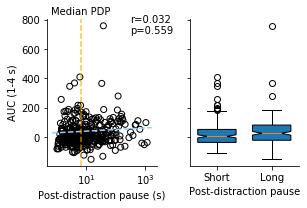

In [96]:

f, [ax1, ax2] = plt.subplots(figsize=(5, 3), ncols=2, sharey=True)
f.subplots_adjust(left=0.2, bottom=0.2, wspace=0.3)

trans = transforms.blended_transform_factory(
            ax1.transData, ax1.transAxes)

ax1.scatter(PDPs, AUCs, marker="o", color="none", edgecolor="k")

ax1.set_ylabel("AUC (1-4 s)")
ax1.set_xlabel("Post-distraction pause (s)")

ax1.set_xscale("log")

slope, intercept, r, p, _ = linregress(PDPs, AUCs)

x1, x2 = ax1.get_xlim()
ax1.plot([x1, x2], [x1*slope + intercept, x2*slope+intercept], "--", color="xkcd:light blue")


stats_str = f"r={r:2.2}\np={p:2.3}" 
ax1.text(300, 0.9, stats_str, transform=trans, ha="left")


median_pdp = np.median(PDPs)
ax1.axvline(median_pdp, linestyle="--", color="orange", alpha=0.7)
ax1.text(median_pdp, 1.03, "Median PDP", ha="center", transform=trans)



AUC_from_shPDPs = [auc for auc, pdp in zip(AUCs, PDPs) if pdp <= median_pdp]
AUC_from_loPDPs = [auc for auc, pdp in zip(AUCs, PDPs) if pdp >= median_pdp]


ax2.boxplot([AUC_from_shPDPs, AUC_from_loPDPs],
            widths=0.7,
            patch_artist =True,
            notch=True)

ax2.set_xticklabels(["Short", "Long"])
ax2.set_xlabel("Post-distraction pause")

for axis in [ax1, ax2]:
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

f.savefig(figfolder+"figs5_pdp_and_auc.pdf")

# ax2.set_yscale("log")



In [98]:
print("Median AUC on short PDP trials is", np.median(AUC_from_shPDPs), "and mean is", np.mean(AUC_from_shPDPs))
print("Median AUC on long PDP trials is", np.median(AUC_from_loPDPs), "and mean is", np.mean(AUC_from_loPDPs))

print(ttest_ind(AUC_from_shPDPs, AUC_from_loPDPs))

print(ttest_ind(np.sqrt(AUC_from_shPDPs), np.sqrt(AUC_from_loPDPs)))

minval = np.abs(min(min(AUC_from_shPDPs), min(AUC_from_loPDPs)))

tr_shPDPs = AUC_from_shPDPs + (minval + 1)
tr_loPDPs = AUC_from_loPDPs + (minval + 1)

print(ttest_ind(np.log(tr_shPDPs), np.log(tr_loPDPs)))

Median AUC on short PDP trials is 5.937955018634052 and mean is 22.276669291787826
Median AUC on long PDP trials is 26.714134466129565 and mean is 37.14036832311489
Ttest_indResult(statistic=-1.566305743532648, pvalue=0.11820182862620787)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-1.0912381721623996, pvalue=0.2759362761061925)


C:\ProgramData\Anaconda3\envs\dis\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
